In [ ]:
# Prediction whether a person is affected from Covid-19 or not from their CT scans, using CNN models built from scratch
# and evaluating the performance 

In [4]:
import os
import cv2
import numpy as np
from PIL.Image import fromarray
# from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
paths = ["C:\\Users\\Lokesh\\PycharmProjects\\pythonProject18\\CT_Cov19\\non-COVID", "C:\\Users\\Lokesh\\PycharmProjects\\pythonProject18\\CT_Cov19\\COVID"]

In [6]:
X = []
y = []
for category_index, path in  enumerate(paths):
    for CTscan in os.listdir(path):
        X.append(img_to_array(fromarray(cv2.resize(cv2.imread(os.path.join(path, CTscan), cv2.IMREAD_GRAYSCALE), (256,256)))))
        y.append(category_index)
X = np.array(X)
y = np.array(y)
# X
# y

In [7]:
X /= 255.0
print(X.shape)
print(y.shape)

(2481, 256, 256, 1)
(2481,)


In [8]:
print(X.min())
print(X.max())

0.0
1.0


In [9]:
print(y.min())
print(y.max())

0
1


In [12]:
import seaborn
import pandas
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of covid/non-covid patients')

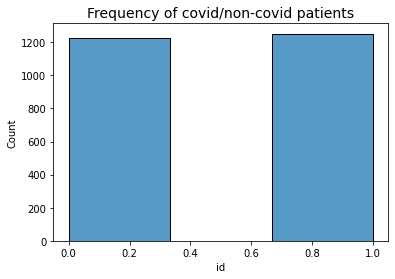

In [14]:
seaborn.histplot(pandas.DataFrame({'id' : y}), x = 'id',bins = 3)
plt.title('Frequency of covid/non-covid patients', fontsize = 14)


In [15]:
info = {0 : 'Non Covid Scan', 1 : 'Covid Scan'}

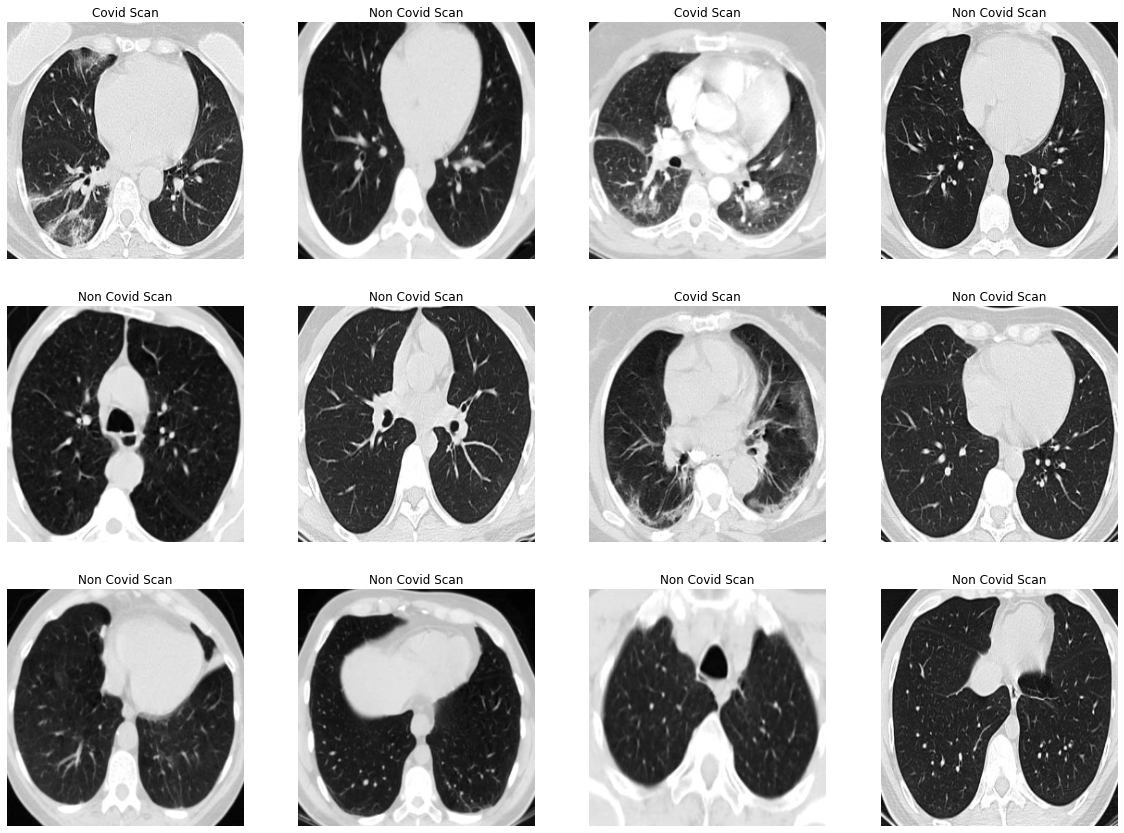

In [16]:
plt.figure(figsize = (20,20))

i = 0
while i < 12 :
    x = np.random.randint(0, 2481)
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[x], 'gray')
    plt.title(info[y[x]])
    plt.axis('off')
    i += 1
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 1)

In [19]:
print(X_train.shape)
print(y_train.shape)

(2232, 256, 256, 1)
(2232,)


In [20]:
print(X_test.shape)
print(y_test.shape)

(249, 256, 256, 1)
(249,)


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_gen = ImageDataGenerator(rotation_range = 5, zoom_range = [0.9, 1.2], horizontal_flip = True, height_shift_range = [-5,5], width_shift_range = [-5,5])

In [23]:
train_gen.fit(X_train)

In [24]:
pointer = train_gen.flow(X_train, y_train)

In [25]:
a, b = pointer.next()

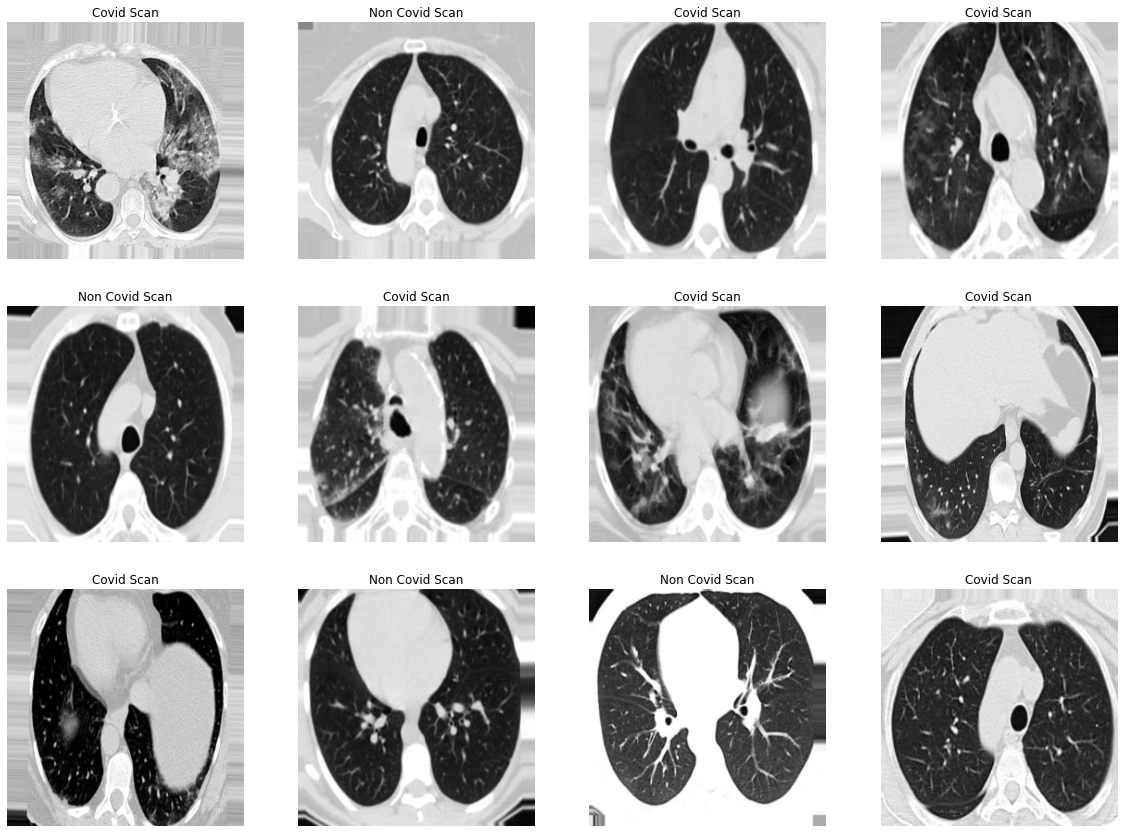

In [26]:
plt.figure(figsize = (20,20))

i = 0
while i < 12 :
    plt.subplot(4, 4, i + 1)
    plt.imshow(a[i], 'gray')
    plt.title(info[b[i]])
    plt.axis('off')
    i += 1
plt.show()

In [27]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [33]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (3,3), padding = 'same', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2)))
    
    return model

In [34]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [35]:
def cnn (filter1, filter2, hidden1, hidden2) :
    
    model = Sequential([
        
        Input((256,256,1,)),
        conv_layer(filter1),
        conv_layer(filter2),
        Flatten(),
        dens_layer(hidden1),
        dens_layer(hidden2),
        
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
    return model

In [36]:
model = cnn(2**3, 2**3, 2**6, 2**5)

In [37]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 128, 128, 8)       112       
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 8)         616       
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                2097472   
_________________________________________________________________
sequential_5 (Sequential)    (None, 32)                2208      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,100,441
Trainable params: 2,100,217
Non-trainable params: 224
__________________________________________

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [42]:
checkp = ModelCheckpoint('./covid-model.h5', save_best_only = True, monitor = 'val_loss', verbose = 1)

In [43]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 100, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/100
35/35 [==============================] - 104s 3s/step - loss: 2.2162 - accuracy: 0.7522 - val_loss: 2.2050 - val_accuracy: 0.5382

Epoch 00001: val_loss improved from inf to 2.20503, saving model to .\covid-model.h5
Epoch 2/100
35/35 [==============================] - 92s 3s/step - loss: 1.6583 - accuracy: 0.8320 - val_loss: 1.7935 - val_accuracy: 0.5382

Epoch 00002: val_loss improved from 2.20503 to 1.79351, saving model to .\covid-model.h5
Epoch 3/100
35/35 [==============================] - 87s 2s/step - loss: 1.2770 - accuracy: 0.8548 - val_loss: 2.0210 - val_accuracy: 0.5382

Epoch 00003: val_loss did not improve from 1.79351
Epoch 4/100
35/35 [==============================] - 86s 2s/step - loss: 1.0547 - accuracy: 0.8634 - val_loss: 1.9257 - val_accuracy: 0.5382

Epoch 00004: val_loss did not improve from 1.79351
Epoch 5/100
35/35 [==============================] - 85s 2s/step - loss: 0.9123 - accuracy: 0.8795 - val_loss: 1.9593 - val_accuracy: 0.5382

Epoch 00005: 

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
# import tensorflow.keras
model = tensorflow.keras.models.load_model('./covid-model.h5')

In [51]:
y_pred = model.predict(X_test, verbose = 1)

8/8 [==============================] - 3s 225ms/step


In [52]:
y_pred = np.around(y_pred)

In [53]:
print(f'Number of 0 labels in test dataset : {y_test[y_test == 0].shape[0]}')
print(f'Number of 1 labels in test dataset : {y_test[y_test == 1].shape[0]}')

Number of 0 labels in test dataset : 115
Number of 1 labels in test dataset : 134


In [54]:
print(f'Number of 0 labels in pred dataset : {y_pred[y_pred == 0].shape[0]}')
print(f'Number of 1 labels in pred dataset : {y_pred[y_pred == 1].shape[0]}')

Number of 0 labels in pred dataset : 115
Number of 1 labels in pred dataset : 134


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       115
           1       0.83      0.83      0.83       134

    accuracy                           0.82       249
   macro avg       0.81      0.81      0.81       249
weighted avg       0.82      0.82      0.82       249



In [59]:
cm = confusion_matrix(y_test, y_pred)
disease_types = ['Covid = +ve','Covid = -ve']

Text(0.5, 145.31999999999996, 'Predicted')

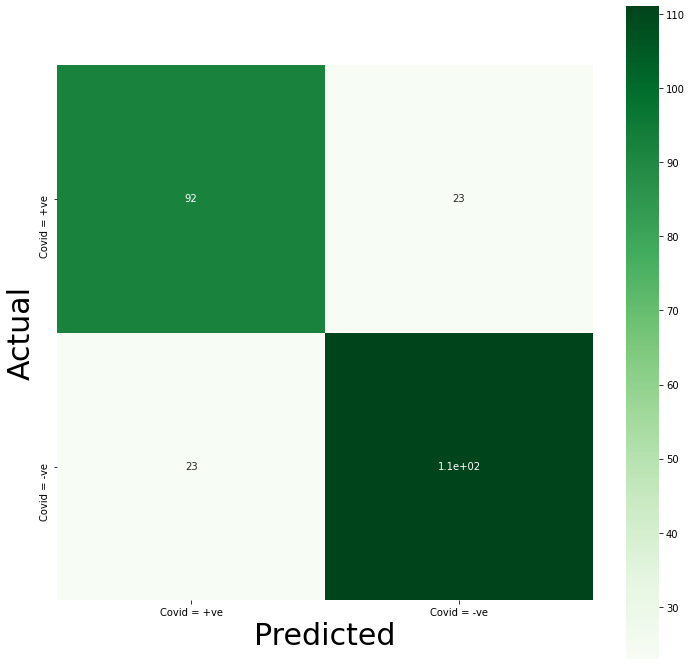

In [60]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)